In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from datetime import datetime

#read a hdf5 file
import h5py


date_to_consider = '2024/05/10'

year = int(date_to_consider.split('/')[0])
#create a new year with only the last two digit of year
year_str = str(year)[2:]

month = int(date_to_consider.split('/')[1])
day = int(date_to_consider.split('/')[2])

dir_path = f'/mnt/ionosphere-data/madrigal_data/raw/gps_data/gps{year_str}0{month}{day}g.003.hdf5'

f = h5py.File(dir_path, 'r')

print("Top-level keys:", list(f.keys()))

metadata_group = f['Metadata']
print("Keys in Metadata group:", list(metadata_group.keys()))

def explore(name, obj):
    print(name)
f.visititems(explore)

Top-level keys: ['Data', 'Metadata']
Keys in Metadata group: ['Data Parameters', 'Experiment Notes', 'Experiment Parameters', 'Independent Spatial Parameters', '_record_layout']
Data
Data/Array Layout
Data/Array Layout/1D Parameters
Data/Array Layout/2D Parameters
Data/Array Layout/2D Parameters/Data Parameters
Data/Array Layout/2D Parameters/dtec
Data/Array Layout/2D Parameters/tec
Data/Array Layout/Layout Description
Data/Array Layout/gdlat
Data/Array Layout/glon
Data/Array Layout/timestamps
Data/Table Layout
Metadata
Metadata/Data Parameters
Metadata/Experiment Notes
Metadata/Experiment Parameters
Metadata/Independent Spatial Parameters
Metadata/_record_layout


In [2]:
from collections import defaultdict

dset = f['Data']['Table Layout']
data = dset[:]
tec = data['tec']


In [ ]:
data

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

print(data['glon'][:30])

# From data column year, monht day hour min sec, select the position of the 20120215 00:00:00 
time_indices = np.where((data['year'] == year) & (data['month'] == month) & (data['day'] == day) & (data['hour'] == 0))[0]
print(f"Number of time indices for {date_to_consider}: {len(time_indices)}")
# Select the data for the given date
data_for_date = data[time_indices]

# --- TEC Map ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(data_for_date['glon'], data_for_date['gdlat'], s = 1, c=np.log10(data_for_date['tec']), cmap='jet', alpha=0.7, transform=ccrs.PlateCarree())


ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
plt.colorbar(label='log10(TEC)')
plt.show()



In [3]:
# Load data
timestamps = f['Data/Array Layout/timestamps'][:]
tec = f['Data/Array Layout/2D Parameters/tec'][:]   # likely shape: (time, height or lat)
dtec = f['Data/Array Layout/2D Parameters/dtec'][:]  # likely shape: (time, height or lat)
glat = f['Data/Array Layout/gdlat'][:]    # if 1D
glon = f['Data/Array Layout/glon'][:]    # if 1D


timestamps_utc = np.array(timestamps, dtype='datetime64[s]')

print("TEC shape:", tec.shape)
print("GLAT shape:", glat.shape)
print("Timestamps shape:", timestamps.shape)
print(np.nanmin(timestamps), np.nanmax(timestamps))
print(timestamps_utc[0])
print(np.nanmin(glat), np.nanmax(glat))
print(np.nanmin(tec), np.nanmax(tec))
print(np.nanmin(dtec), np.nanmax(dtec))

print(tec[0])


TEC shape: (180, 360, 288)
GLAT shape: (180,)
Timestamps shape: (288,)
1715299200.0 1715385300.0
2024-05-10T00:00:00
-90.0 89.0
9.5e-05 273.290039
0.076422 577.770996
[[     nan      nan 5.392105 ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan 5.942129 ...      nan      nan      nan]
 ...
 [     nan      nan      nan ... 5.205952      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]]


In [ ]:
#create a dataframe which has as information Year month day hour min sec tec dtec glat glon 
#in paritucular each row is associated only to one glat and glon so that and we have multiple lines with the same timestamp
#separate timestamp into year month day hour min sec
import pandas as pd

data_list = []

for i in range(len(timestamps)):
    for j in range(len(glat)):
        for y in range(len(glon)):
            data_list.append({
                'year': timestamps_utc[i].astype(object).year,
                'month': timestamps_utc[i].astype(object).month,
                'day': timestamps_utc[i].astype(object).day,
                'hour': timestamps_utc[i].astype(object).hour,
                'min': timestamps_utc[i].astype(object).minute,
                'sec': timestamps_utc[i].astype(object).second,
                'tec': tec[j, y, i],
                'dtec': dtec[j, y, i],
                'gdlat': glat[j],
                'glon': glon[y]
            })


df = pd.DataFrame(data_list)
print(df.head())


# for i, ts in enumerate(timestamps_utc):
#     for j in range(len(glat)):
#         for y in range(len(glon)):
#             data_list.append({
#                 'timestamp': ts,
#                 'tec': tec[j, y, i],
#                 'dtec': dtec[j, y, i],
#                 'glat': glat[j],
#                 'glon': glon[y]
#             })
# df = pd.DataFrame(data_list)
# print(df.head())


In [ ]:

np.savetxt(f'/mnt/ionosphere-data/madrigal_data/gps_tec_{date_to_consider.replace("/", "")}.txt', df.values, fmt='%s', delimiter='\t', header='\t'.join(df.columns), comments='')


In [ ]:
time_indices = np.where((df['year'] == 2012) & (df['month'] == 2) & (df['day'] == 16) & (df['hour'] == 0))[0]
print(f"Number of time indices for {date_to_consider}: {len(time_indices)}")
# Select the data for the given date
data_for_date = df.iloc[time_indices]

print(data_for_date.head())

# --- TEC Map ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(data_for_date['glon'], data_for_date['gdlat'], s = 1, c=np.log10(data_for_date['tec']), cmap='jet', alpha=0.7, transform=ccrs.PlateCarree())


ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
plt.colorbar(label='log10(TEC)')
plt.show()

#save df as a txt file

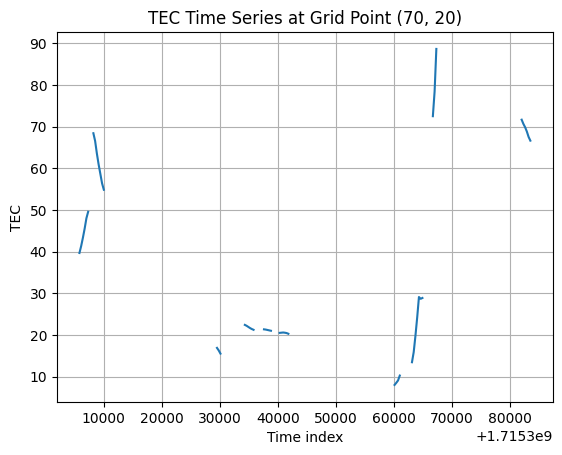

In [4]:
import matplotlib.pyplot as plt
# Choose a grid point
i = 70  # Example index for latitude
j = 20  # Example index for longitude

tec_time_series = tec[i, j, :]  # shape: (288,)
plt.plot(timestamps, tec_time_series)
plt.xlabel('Time index')
plt.ylabel('TEC')
plt.title(f'TEC Time Series at Grid Point ({i}, {j})')
plt.grid(True)
plt.show()

/var/tmp/ipykernel_3360203/4039358646.py:3: RuntimeWarning: Mean of empty slice
  tec_snapshot = np.nanmean(tec[:, :, time_idx:time_idx+5], axis = 2)  # Summing over the last dimension (time)


Number of NaN values in TEC snapshot: 38808/64800= 59.89%
-90.0 -180.0


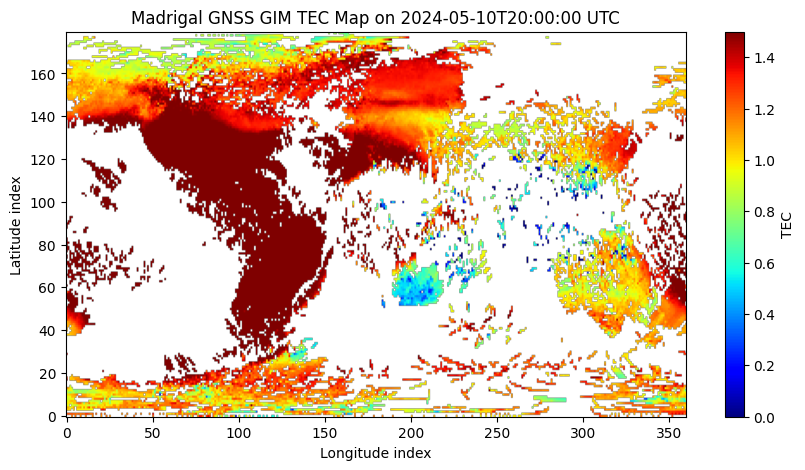

/var/tmp/ipykernel_3360203/4039358646.py:21: RuntimeWarning: Mean of empty slice
  dtec_snapshot = np.nanmean(dtec[:, :, time_idx:time_idx+5], axis = 2)  # Summing over the last dimension (time)


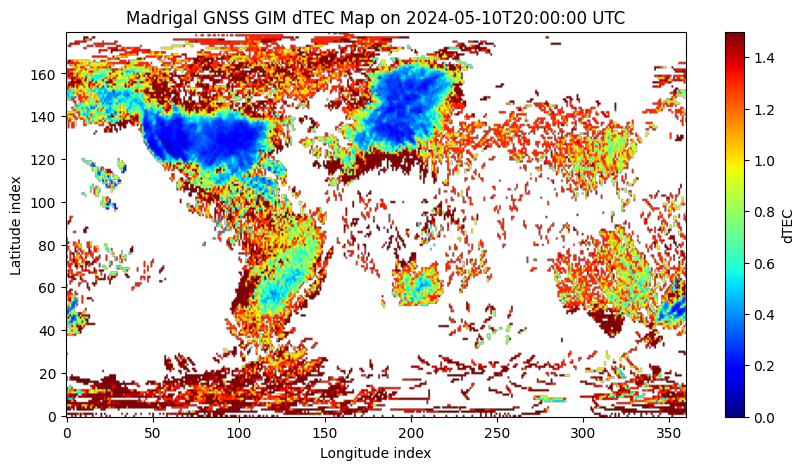

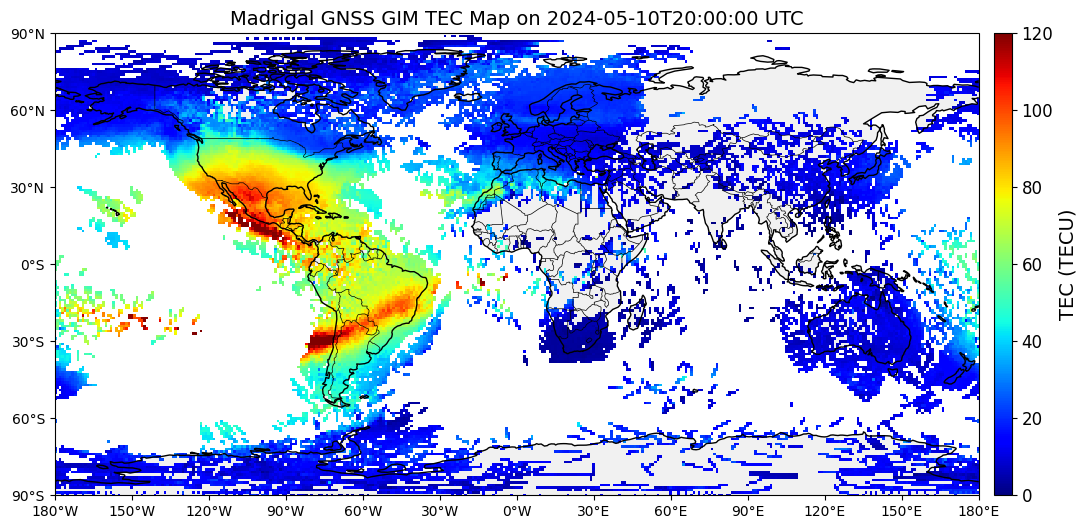

In [5]:
time_idx = 20*12
time_utc = timestamps_utc[time_idx]
tec_snapshot = np.nanmean(tec[:, :, time_idx:time_idx+5], axis = 2)  # Summing over the last dimension (time)
#tec_snapshot = tec[:, :, time_idx]

#count the number of pixels with nan values 
nan_count = np.sum(np.isnan(tec_snapshot))
print(f'Number of NaN values in TEC snapshot: {nan_count}/{tec_snapshot.size}= {nan_count/tec_snapshot.size:.2%}')

print(glat[0],glon[0])

fig = plt.figure(figsize=(10, 5))
plt.imshow(np.log10(tec_snapshot), origin='lower', aspect='auto', cmap='jet', vmin = 0, vmax = 1.5)
plt.colorbar(label='TEC')
plt.title(f'Madrigal GNSS GIM TEC Map on {time_utc} UTC')
plt.xlabel('Longitude index')
plt.ylabel('Latitude index')
plt.show()


dtec_snapshot = np.nanmean(dtec[:, :, time_idx:time_idx+5], axis = 2)  # Summing over the last dimension (time)
#dtec_snapshot = dtec[:, :, time_idx]

fig = plt.figure(figsize=(10, 5))
plt.imshow(dtec_snapshot, origin='lower', aspect='auto', cmap='jet', vmin = 0, vmax = 1.5)
plt.colorbar(label='dTEC')
plt.title(f'Madrigal GNSS GIM dTEC Map on {time_utc} UTC')
plt.xlabel('Longitude index')
plt.ylabel('Latitude index')
plt.show()


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- TEC Map ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tec_plot = ax.pcolormesh(glon, glat, tec_snapshot, cmap='jet', vmin=0, vmax = 120, shading='auto')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.set_extent([np.min(glon), np.max(glon), np.min(glat), np.max(glat)], crs=ccrs.PlateCarree())
#add the axis ticks and labels
ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(-x)}°W'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(-y)}°S'))

# --- Smaller Colorbar ---
# [left, bottom, width, height] in figure coordinates (0 to 1)
cbar_ax = fig.add_axes([0.91, 0.11, 0.015, 0.77])
cbar = fig.colorbar(tec_plot, cax=cbar_ax, orientation='vertical')
cbar.set_label('TEC (TECU)', fontsize=14)
cbar.ax.tick_params(labelsize=12)

ax.set_title(f'Madrigal GNSS GIM TEC Map on {time_utc} UTC', fontsize=14)
# plt.colorbar(tec_plot, ax=ax, orientation='vertical', label='log10(TEC)')
plt.show()


Variables in JPLD file: dict_keys(['varepochs', 'time', 'lat', 'lon', 'tecmap', 'tecflag'])
<class 'netCDF4.Variable'>
float64 time(nepochs)
    description: begin time of each 15-minute interval
    units: seconds past J2000 (1/1/2000 12:00 UT)
unlimited dimensions: 
current shape = (96,)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4.Variable'>
float32 tecmap(nepochs, nlats, nlons)
    units: TECU (1x10^16 el m-2)
    coordinates: time lat lon
unlimited dimensions: 
current shape = (96, 180, 360)
filling on, default _FillValue of 9.969209968386869e+36 used
89.5 -179.5
Time datetimes: [datetime.datetime(2024, 5, 10, 0, 0), datetime.datetime(2024, 5, 10, 0, 15), datetime.datetime(2024, 5, 10, 0, 30), datetime.datetime(2024, 5, 10, 0, 45), datetime.datetime(2024, 5, 10, 1, 0), datetime.datetime(2024, 5, 10, 1, 15), datetime.datetime(2024, 5, 10, 1, 30), datetime.datetime(2024, 5, 10, 1, 45), datetime.datetime(2024, 5, 10, 2, 0), datetime.datetime(2024, 5, 1

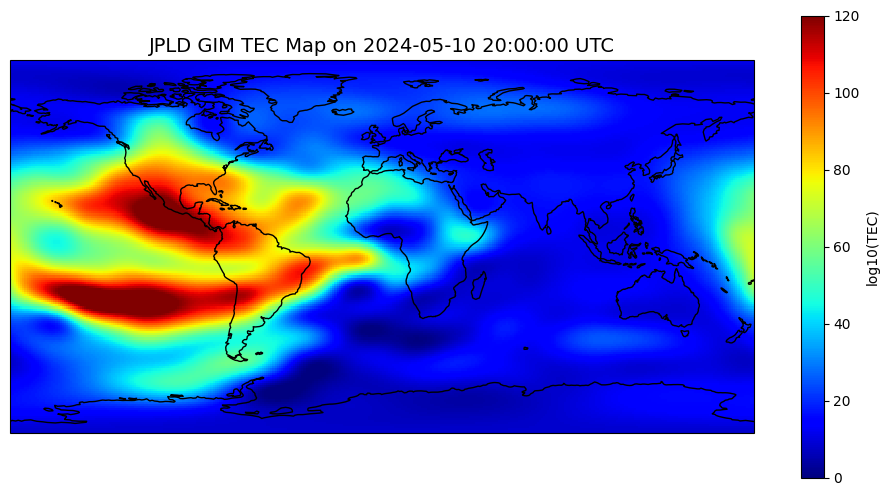

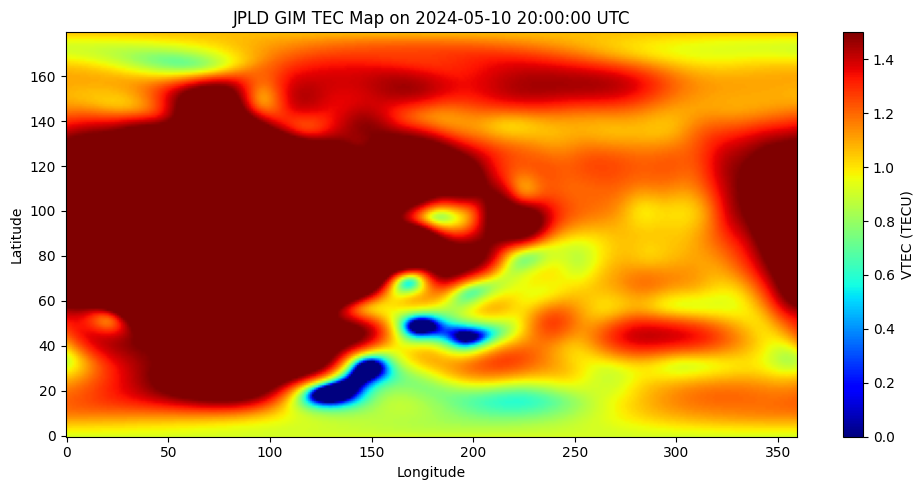

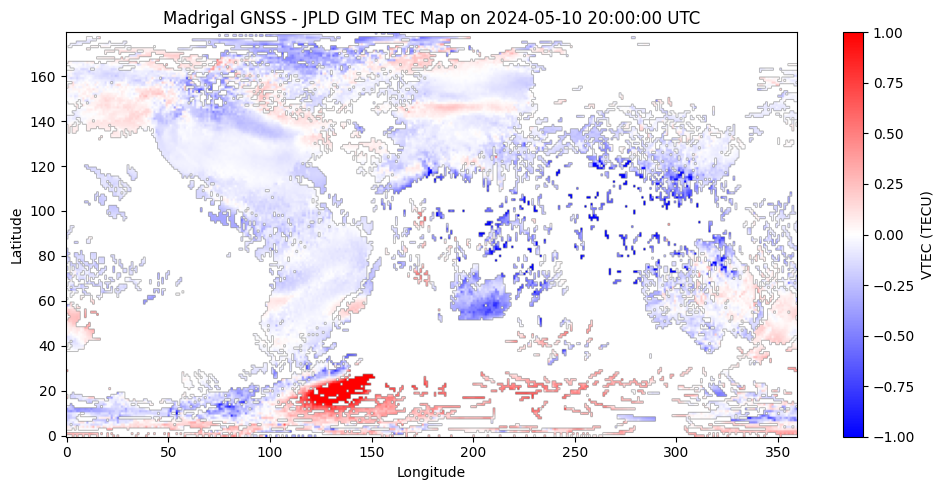

In [6]:
import os
import gzip
import io
from netCDF4 import Dataset
from datetime import datetime, timedelta


def convert_to_doy(date_str):
    """
    Convert a date string in 'dd/mm/yyyy' format to day of year (DOY).
    """
    try:
        date_obj = datetime.strptime(date_str, "%d/%m/%Y")
        doy = date_obj.timetuple().tm_yday
        return doy
    except ValueError:
        return "Invalid date format. Use dd/mm/yyyy"

day_to_conv = convert_to_doy(datetime(year, month, day).strftime("%d/%m/%Y"))

if len(str(day_to_conv)) == 1:
    day_to_conv = f'00{day_to_conv}'
elif len(str(day_to_conv)) == 2:
    day_to_conv = f'0{day_to_conv}'
elif len(str(day_to_conv)) == 3:
    day_to_conv = str(day_to_conv)


#quick comparison with jpld file 
jpld_dir_path =  f'/mnt/ionosphere-data/jpld/raw/{year}/'

#create aroutine to convert dd/mm/yyyy to day of the year

jpld_file = f'jpld{day_to_conv}0.{year_str}i.nc.gz'

compressed_path = os.path.join(jpld_dir_path, jpld_file)

with gzip.open(compressed_path, 'rb') as f:
    decompressed_data = f.read()

nc_buffer = io.BytesIO(decompressed_data)
nc = Dataset('in_memory.nc', mode='r', memory=nc_buffer.read())

#print(nc)
print("Variables in JPLD file:", nc.variables.keys())
print(nc.variables['time'])
print(nc.variables['tecmap'])  
print(nc.variables['lat'][0], nc.variables['lon'][0])

j2000 = datetime(2000, 1, 1, 12, 0, 0)
time_seconds = nc.variables['time'][:]
time_datetimes = [j2000 + timedelta(seconds=float(t)) for t in time_seconds]
print("Time datetimes:", time_datetimes)

target_dt = datetime(year, month, day, 20, 0, 0)
time_index = min(range(len(time_datetimes)), key=lambda i: abs(time_datetimes[i] - target_dt))

print("Closest available time:", time_datetimes[time_index])

import numpy as np
import matplotlib.pyplot as plt

# Read lat/lon and tec
tecmap_jpld = nc.variables['tecmap'][:]  # (96, 180, 360)
lat = nc.variables['lat'][:]  # (180,)
lon = nc.variables['lon'][:]  # (360,)

# Extract the map at the desired time index
vtec_map = tecmap_jpld[time_index, :, :]  # shape: (lat, lon)

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# --- TEC Map ---
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
tec_plot = ax.pcolormesh(lon, lat, vtec_map, cmap='jet', vmin=0, vmax=120, shading='auto')
ax.coastlines()
#ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
ax.set_title(f'JPLD GIM TEC Map on {time_datetimes[time_index]} UTC', fontsize=14)
plt.colorbar(tec_plot, ax=ax, orientation='vertical', label='log10(TEC)')
plt.show()

vtec_map = np.flipud(vtec_map)  # Flip latitudes if necessary


# Plot
plt.figure(figsize=(10, 5))
plt.imshow(np.log10(vtec_map), origin='lower', aspect='auto', cmap='jet', vmin = 0, vmax = 1.5)
plt.title(f'JPLD GIM TEC Map on {time_datetimes[time_index]} UTC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='VTEC (TECU)')
plt.tight_layout()
plt.show()


# difference map 
# Interpolate JPLD map to Madrigal grid if necessary
# For simplicity, assuming both maps are on the same grid here


plt.figure(figsize=(10, 5))
plt.imshow(np.log10(tec_snapshot) - np.log10(vtec_map), origin='lower', aspect='auto', cmap='bwr', vmin = -1, vmax = 1)
plt.title(f'Madrigal GNSS - JPLD GIM TEC Map on {time_datetimes[time_index]} UTC')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='VTEC (TECU)')
plt.tight_layout()
plt.show()


Closest available time: 2024-05-10 16:00:00


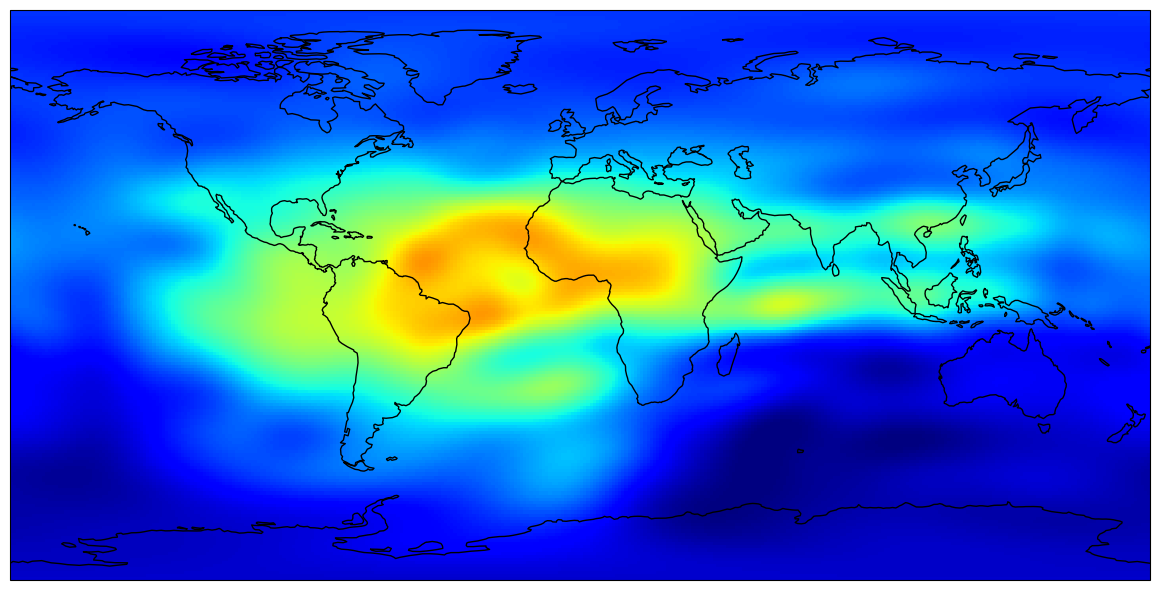

Saved figure to /home/simone/jpld_tec_map_20240510_1600.png
Closest available time: 2024-05-10 17:00:00


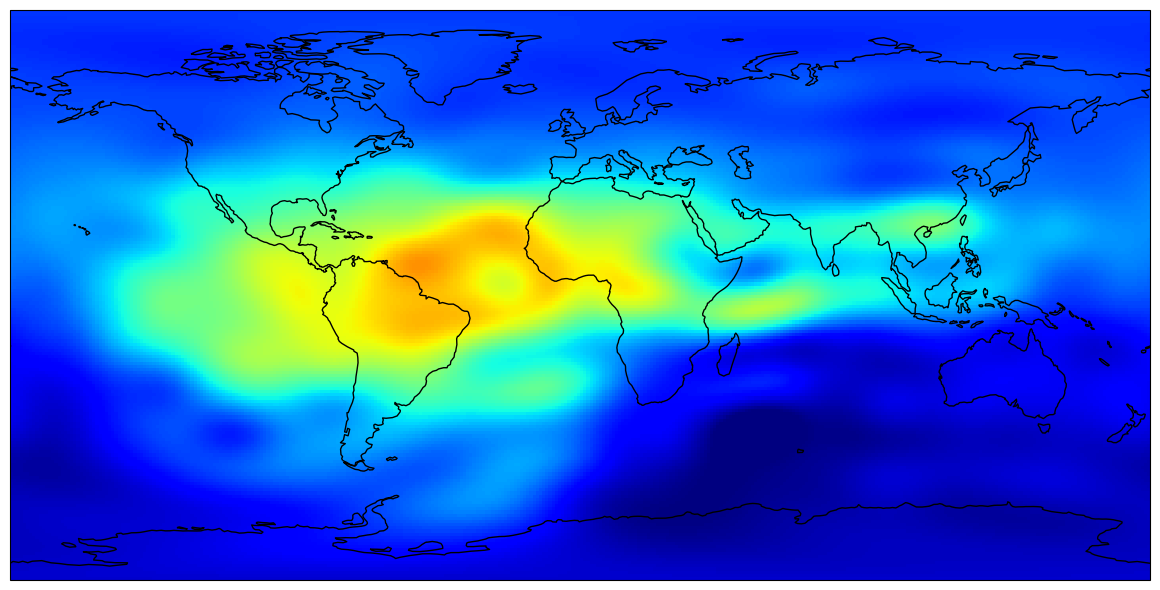

Saved figure to /home/simone/jpld_tec_map_20240510_1700.png
Closest available time: 2024-05-10 18:00:00


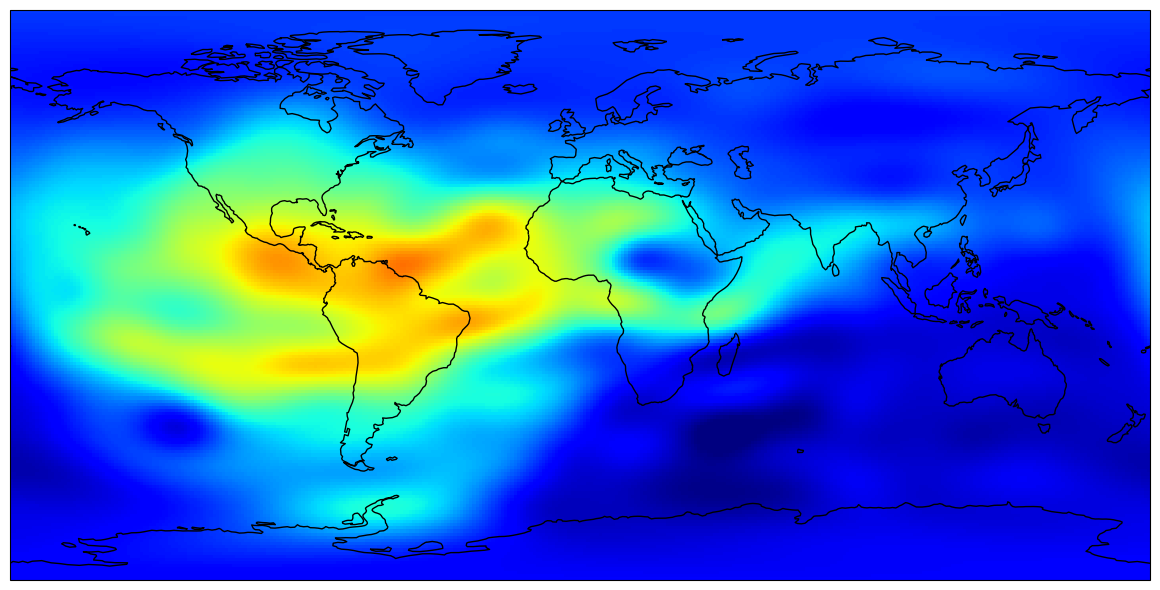

Saved figure to /home/simone/jpld_tec_map_20240510_1800.png
Closest available time: 2024-05-10 19:00:00


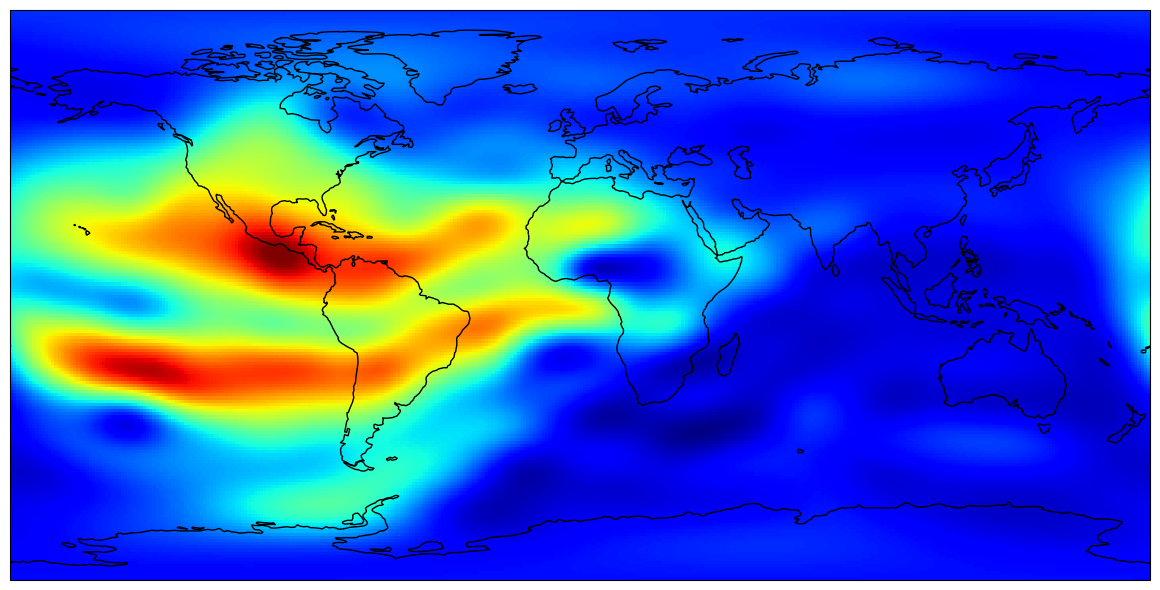

Saved figure to /home/simone/jpld_tec_map_20240510_1900.png
Closest available time: 2024-05-10 20:00:00


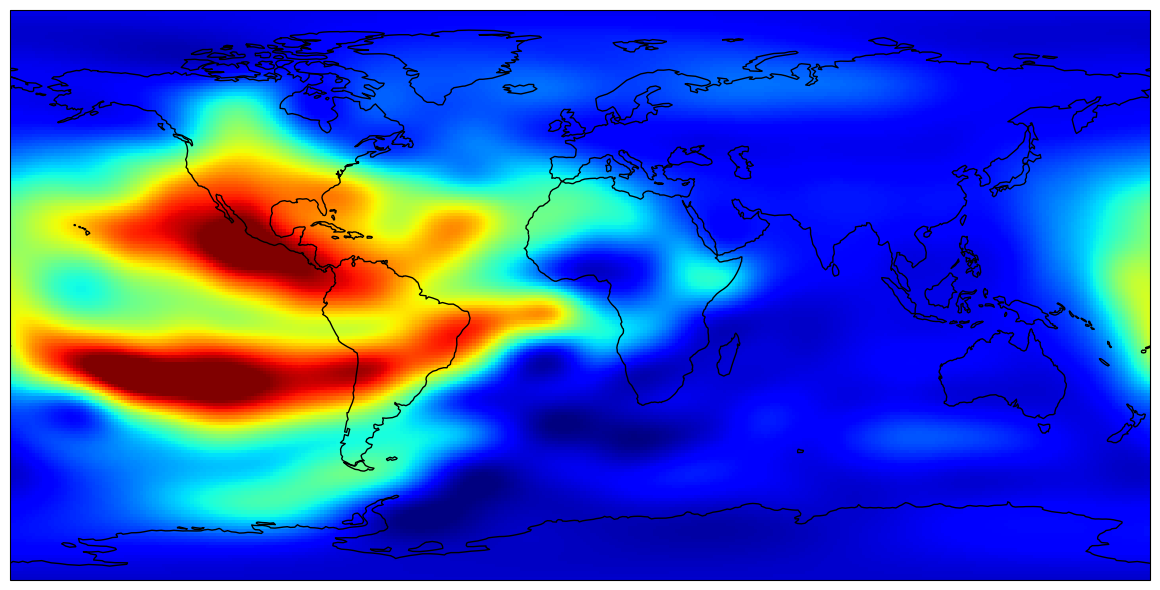

Saved figure to /home/simone/jpld_tec_map_20240510_2000.png
Closest available time: 2024-05-10 21:00:00


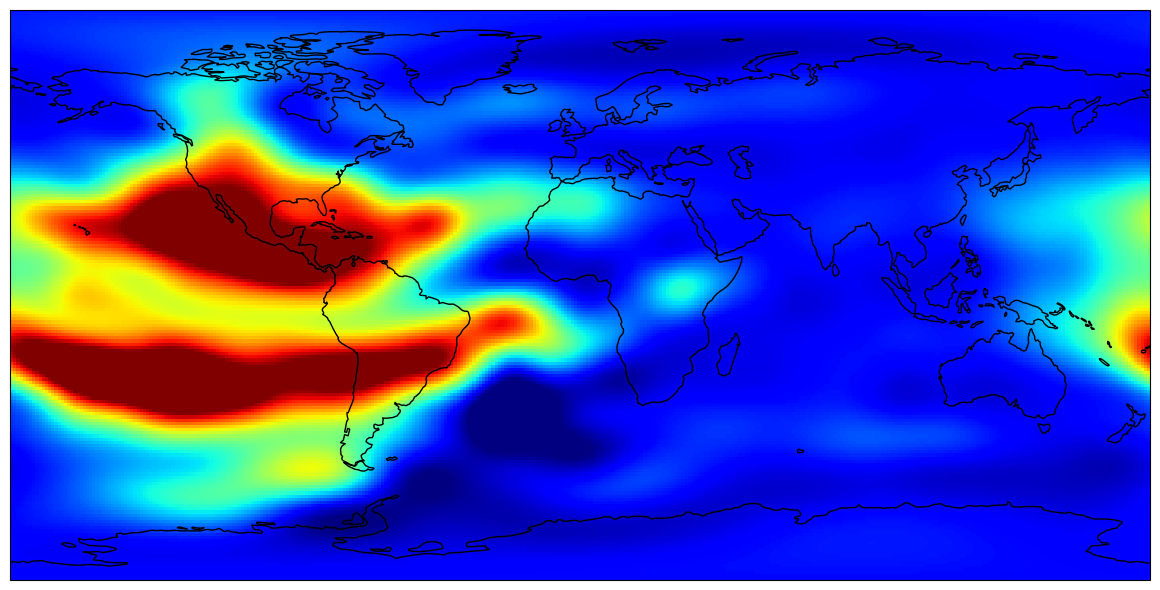

Saved figure to /home/simone/jpld_tec_map_20240510_2100.png
Closest available time: 2024-05-10 22:00:00


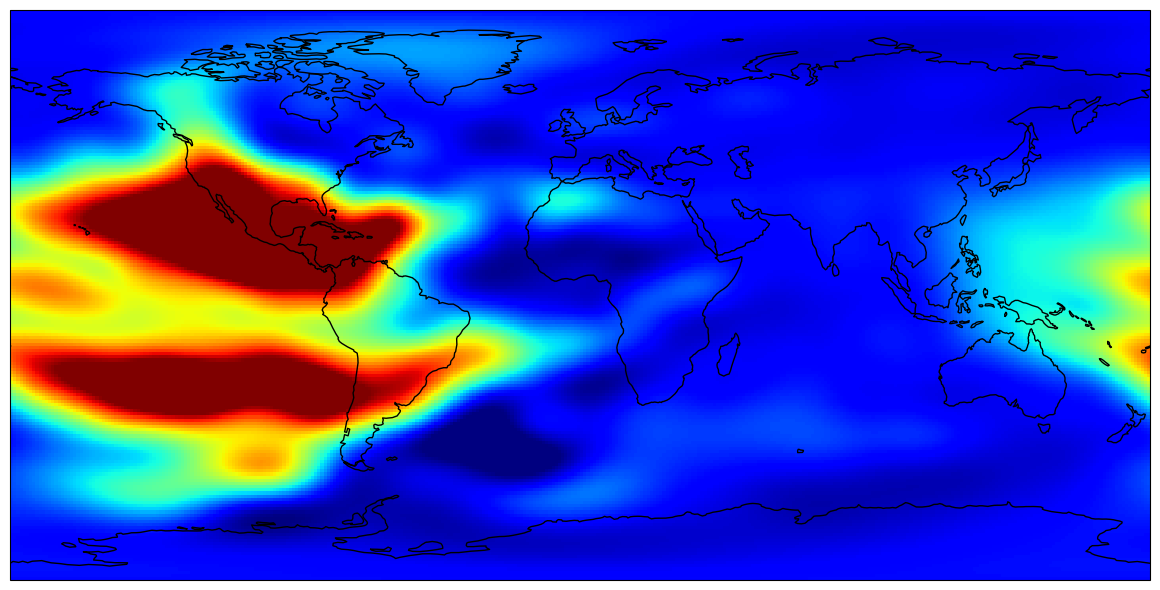

Saved figure to /home/simone/jpld_tec_map_20240510_2200.png
Closest available time: 2024-05-10 23:00:00


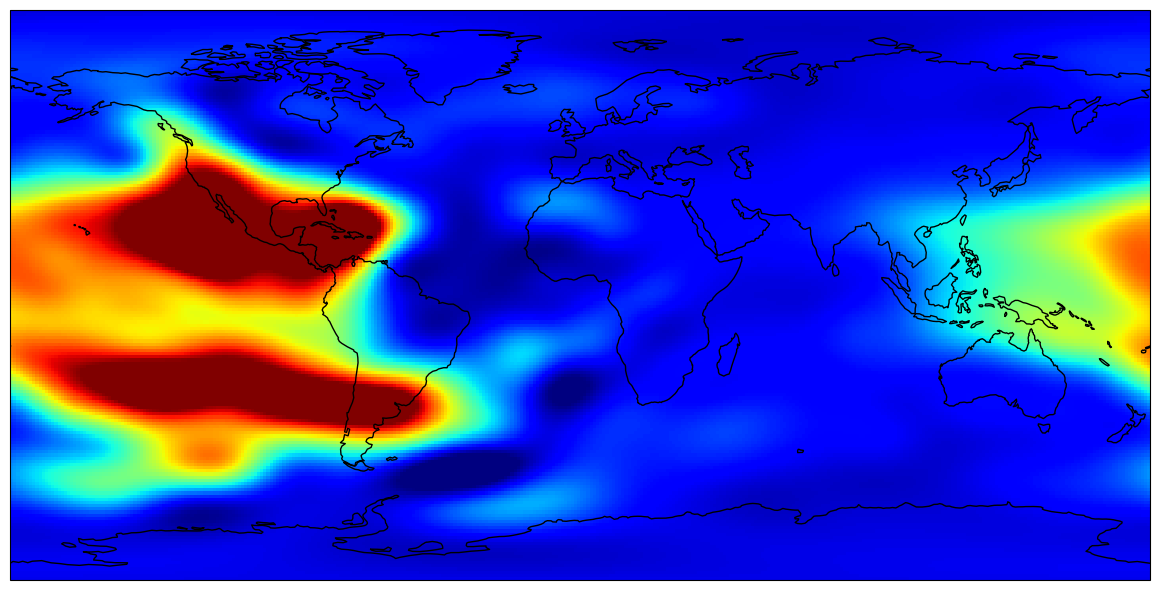

Saved figure to /home/simone/jpld_tec_map_20240510_2300.png


In [16]:
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os 

# Loop over hours from 16 to 23
for hour in range(16, 24):
    # Define the target datetime
    target_dt = datetime(year, month, day, hour, 0, 0)

    # Find the closest available time
    time_index = min(range(len(time_datetimes)), key=lambda i: abs(time_datetimes[i] - target_dt))
    print("Closest available time:", time_datetimes[time_index])

    # Extract TEC map for that time
    vtec_map = tecmap_jpld[time_index, :, :]  # shape: (lat, lon)

    # --- Plot TEC Map ---
    fig = plt.figure(figsize=(12, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
    
    tec_plot = ax.pcolormesh(lon, lat, vtec_map, cmap='jet', vmin=0, vmax=120, shading='auto')

    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    #ax.set_title(f'JPLD GIM TEC Map on {time_datetimes[time_index]} UTC', fontsize=16)

    #add the axis ticks and labels
    # ax.set_xticks(np.arange(-180, 181, 30), crs=ccrs.PlateCarree())
    # ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    # ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(-x)}°W'))
    # ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(-y)}°S'))

    # --- Smaller Colorbar ---
    # [left, bottom, width, height] in figure coordinates (0 to 1)
    # cbar_ax = fig.add_axes([0.91, 0.11, 0.015, 0.77])
    # cbar = fig.colorbar(tec_plot, cax=cbar_ax, orientation='vertical')
    # cbar.set_label('TEC (TECU)', fontsize=14)
    # cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.show()

    #save fig into folder
    output_dir = '/home/simone/'
    output_path = os.path.join(output_dir, f'jpld_tec_map_{year}{month:02d}{day:02d}_{hour:02d}00.png')

    #check if the output_dir exists
    if not os.path.exists(output_dir):
       os.makedirs(output_dir)

    fig.savefig(output_path, dpi=300)
    plt.close(fig)
    print(f'Saved figure to {output_path}')



In [ ]:
from PIL import Image
import os

# Folder containing the PNG files
image_folder = '/home/simone/'
# Output GIF path
output_gif = '/home/simone/outputN.gif'

# Sort and load images
images = []
for file_name in sorted(os.listdir(image_folder)):
    if file_name.endswith('00.png'):
        file_path = os.path.join(image_folder, file_name)
        img = Image.open(file_path)
        images.append(img.convert('RGBA'))

# Save as GIF
if images:
    images[0].save(
        output_gif,
        save_all=True,
        append_images=images[1:],
        duration=1000,   # Duration between frames in ms
        loop=0          # 0 means loop forever
    )
    print(f"GIF saved as {output_gif}")
else:
    print("No PNG images found.")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Dummy data
lon = np.linspace(-180, 180, 361)
lat = np.linspace(-90, 90, 181)
lon2d, lat2d = np.meshgrid(lon, lat)
vtec_map = np.random.rand(len(lat), len(lon)) * 120
time_datetimes = [f"2025-08-13 {hour:02d}:00" for hour in range(15)]

# Grid size
nrows, ncols = 3, 5

# Create grid
fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(18, 5.4),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

axes = axes.flatten()

for idx, ax in enumerate(axes):
    tec_plot = ax.pcolormesh(
        lon, lat, vtec_map,
        cmap='jet', vmin=0, vmax=120, shading='auto'
    )
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgray', alpha=0.3)
    ax.set_title(f'TEC Map on {time_datetimes[idx]} UTC', fontsize=9)

    # # Show ticks only for first column (y-axis) and last row (x-axis)
    # row, col = divmod(idx, ncols)
    # if col == 0:
    #     ax.set_yticks(np.arange(-90, 91, 30), crs=ccrs.PlateCarree())
    #     ax.yaxis.set_major_formatter(
    #         plt.FuncFormatter(lambda y, _: f'{int(y)}°N' if y > 0 else f'{int(-y)}°S')
    #     )
    # else:
    #     ax.set_yticks([])

    # if row == nrows - 1:
    #     ax.set_xticks(np.arange(-180, 181, 60), crs=ccrs.PlateCarree())
    #     ax.xaxis.set_major_formatter(
    #         plt.FuncFormatter(lambda x, _: f'{int(x)}°E' if x > 0 else f'{int(-x)}°W')
    #     )
    # else:
    #    ax.set_xticks([])

    # Show ticks only for first column (y-axis) and last row (x-axis)
    row, col = divmod(idx, ncols)

    # Y-axis ticks for first column
    if col == 0:
        ax.set_yticks([90, 45, 0, -45, -90], crs=ccrs.PlateCarree())
        ax.yaxis.set_major_formatter(
            plt.FuncFormatter(
                lambda y, _: (
                    f'{abs(int(y))}°N' if y > 0 else 
                    ('0°' if y == 0 else f'{abs(int(y))}°S')
                )
            )
        )
    else:
        ax.set_yticks([])

    # X-axis ticks for last row
    if row == nrows - 1:
        ax.set_xticks([-180, -90, 0, 90, 180], crs=ccrs.PlateCarree())
        ax.xaxis.set_major_formatter(
            plt.FuncFormatter(
                lambda x, _: (
                    f'{abs(int(x))}°E' if x > 0 else 
                    ('0°' if x == 0 else f'{abs(int(x))}°W')
                )
            )
        )


    else:
        ax.set_xticks([])




# Reduce space between rows and columns
plt.subplots_adjust(wspace=0.2, hspace=0.2)

# Add one shared colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
# cbar = fig.colorbar(tec_plot, cax=cbar_ax, orientation='vertical')
# cbar.set_label('TEC (TECU)', fontsize=14)
# cbar.ax.tick_params(labelsize=12)

plt.show()
